# Module 3: Introduction to Analyzing Spectra

This module will showcase some of the techniques that we use to analyze spectra. Things that we will go over in this notebook are:

1. How to compute the redshift of a source
2. How to fit a continuum to the spectrum
3. How to measure Emission Lines
4. How to fit multi-component models



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from astropy.io import fits
from astropy.table import Table
from astropy import units as u

plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 15

# Introduction to Spectral Analysis

When we are looking at any astronomical object what we are really doing is studying the light from that object. The light we recieve provides us with valuable information about the chemical composition, the strength of the ionization field that leads to emission lines, as well as information about the dust properties within a galaxy and so much more. When we are studying galaxies, in escense, what we are studying is the summation of all the light emitted (typically by stars) in that galaxy as well as all the post processing of that light through dust and gas. 

## How do we measure a Spectrum

Typically when we measure a spectra, we use a slit. A slit is an optical mask that allow light through a small area (the slit) and blocks light from all other areas. The image below shows an example of a slit. With the rectangle shown where the spectrograph is getting the light from the galaxy.

![alt text](slit_dispersions.png "Shutter")
[citation](https://users.physics.unc.edu/~gcsloan/research/longslit.html)

The light from the galaxy enters the box or $\textbf{slit}$ before encountering a disperser that spreads out the light as a function of wavelength. At each wavelength we measure the number of photons that hit the detector, and the resulting distribution of intensity of light as a function of wavelegnth (or frequency) is a spectrum.

Initially, spectra are two-dimensional (2D) with a spatial axis (measuring position along the slit) and spectral axis (measuring the wavelength (or frequency) of light). One can think of a 2D spectrum as a series of images of the slit, each containing a specific wavelenght of light, all lined up in a row from shortest to longest wavelength. An example of a 2D spectrum is shown below in the upper panel of the below figure. 


![alt text](spectrum.png "Spectrum")
[citation](https://dawn-cph.github.io/dja/spectroscopy/nirspec/)



2D spectra are useful for more advanced spectral analysis, but typically, one collapses a 2D spectrum into as 1D spectrum for most applications. This is done by summing the spatially distributed flux in each column of the spectrum to from a 1D array of total fluxes as a function of wavelength (see lower panel). As such, note that the wavelenghts with high flux (colored purple in the 2D spectrum) therefore correspond to wavelengths with high flux in the 1D spectrum. 

## Spectral Resolution

One of the most important aspect of a spectroscopic instrument is the resolution. You can think of the resolution of an instrument as how finely separated are two neighboring wavelengths. The higher the resolution the smaller the spacing between neighboring wavelengths. This is super important if you need to be able to resolve doublets, which are two emission lines in very close proximity. If the resolution is really low you can imaging that doublets would actually look like one line instead of two. There are ways to fit emission lines with multi-Gaussian when the resolution is low and back out information, with some assumption, which we will cover in the end of the notebook.
You can see an example of the difference that resolution makes in the following image where with a higher resolution spectra you can really make out the individual emission features where if you have a lower resolution spectra the lines can blur together and gaining information from that spectra is more difficult, but not impossible.

![alt text](effect_of_resolution.jpg "resolution")

[citation](https://www.horiba.com/cze/scientific/technologies/raman-imaging-and-spectroscopy/raman-spectrometer-presentation/)

# What does a Spectra Tell Us?

A spectrum is a superposition of everything emitting and absorbing light. The components that make up a spectrum are the continuum, emission and absorption features. Let's cover each of them in detail.

## Continuum

One of the things that gets discussed early on in astrophysics is the fact that stars are as close to a black body as possible. That means that they emit light across a wide range of wavelengths and each star has a peak wavelength where the intensity of this light is the maximum. When we look at a spectrum of a star the overall curve we see is this underlying shape or continuum, that is determined by the star's temperature. 

![alt text](stellar_continuum.png "continuum")

[citation](http://spiff.rit.edu/classes/phys301/lectures/blackbody/blackbody.html)

When we look at a galaxy spectrum what we are seeing is a summation of all the stars conttibuting to the continuum and every star contributes differently. The highest mass stars ($> 50 M_{\odot}$), for example, contribute more of their light to the UV-wavelengths,where lower mass stars contribute more to the optical and infrared. So the shape of the continuum for a galaxy is not a simple black-body curve like a star but a summation of a lot of black body and depending on the populations of stars within the galaxy can alter the shape of the continuum we see from galaxy to galaxy. 

For example, I told you that high mass stars emit more UV light than less massive stars. So if a galaxy has lots of high mass stars then we would expect the UV continuum would be higher than a galaxy that does not have as many high mass stars. 

Note: it is not that the stars do not emit at these wavelengths, but their contribution at those wavelengths is less than other stars


## Emission and Absorption Lines

When the light from a star encounters some cold gas as it makes its way to our detector the intermediate gas can absorb some of the light, this absorption can only occur at very discrete energy levels or at discrete wavelengths. What this does is that the electrons in the gas go from their ground state energy level to a level with higher energy or to an excited state. Since this light that we would normally would have seen got absorbed by the gas we will see a dip in the intensity of light around the wavelength that got absorbed. Because we see a dip and the cause is from atoms absorbing the light we call these Absorption Lines. 

The complement of these are emission lines and the way we get this is that you have gas in an excited state (so not the ground state), this upper energy level is not very stable for atoms and the electrons want to go back to the ground state. So what the electrons do is that they go from a higher energy level to a lower level and in the process they emit a photon that exactly matches the difference in energy between the two levels. This occurs at very specific wavelengths, very similar to the absorption mechanism, and as a result we will see a boost in the signal at those specific wavelengths since this gas is adding photons at that particular wavelength. This results in a spike in the spectrum.


## Using Emission and Absorption Lines to Understand its Properties


![alt text](jwst_spectra.png)
[citation](https://arxiv.org/html/2403.07103v1)


1. Redshift

Spectra tell us so much information. For one, we can use the spectra to find the redshift of the source. Do you see those vertical dashed lines in the 1D-spectra above? Those lines occur at a fixed wavelength and we can measure how far off those emission lines are from where they are from the rest frame. By using the equation below we can get the redshift. 

$z = \lambda_{obs}/\lambda_{rest} - 1$

$\lambda_{obs}$ is the observed wavelength of the emission line. $\lambda_{rest}$ is the rest frame wavelength of an emission lines, typically these rest frame values are computed in a laboratory and are super accurate. we recommend you look at this [page](http://astronomy.nmsu.edu/drewski/tableofemissionlines.html) to get a sense of all the emission lines people have found in astrophysical objects.

2. Galaxy Properties

The strength of those emission lines can give us insight into the internal galaxy properties. By measuring the flux of lines across the spectra and by using certain equations we can get relevant galaxy properties like; metallicity, ionization parameter, dust content, Star Formation Rate, and more. The way that we measure the flux of an emission line is by fitting the line to a Gaussian Model as emission lines are really well modeled by a Gaussian. The integral of this Gaussian will tell you the integrated flux of this line. Depending on the line you can measure properties from this single line or you would need to measure other lines and and use line ratios to get galaxy properties. We cover in this notebook how to fit a line to a Gaussian Model using curve_fit and in part 2 and 3 how we can use a Bayesian model to perform the fitting. 

# A Note on Units

When dealing with spectra they will most likely come in one of two flux units: $F_{\nu}$ or $F_{\lambda}$. The units for each of these differ slightly where in $F_{\nu}$ the base cgs unit is $erg/s/cm^2/Hz$, other units are scaled versions of this base unit such as a Jansky (Jy for short) which is 1 $\times$ $10^{-23}$ $erg/s/cm^2/Hz$. The typical fluxes observed in distant galaxies are of order $10^{-30}$ - $10^{-26}$ for $erg/s/cm^2/Hz$. 

In $F_{\lambda}$, the base cgs unit is $erg/s/cm^2/\AA$. The typical fluxes observed in distant galaxies in these units are of order $10^{-21}$ - $10^{-16}$ in $erg/s/cm^2/\AA$. 

## Converting Between the Two

One of the things we will be working on in this notebook and whenever you are dealing with spectra is measuring the flux of a source for that we need the units to be in units of $erg/s/cm^2$. This means that if you are measuring fluxes, you will need to be careful about the units of the spectrum you are fitting. If you have a spectrum that is in $F_{\nu}$ and you need to get to $F_{\lambda}$ the way to do that is to apply the following equation:

   $ F_{\lambda} = \frac{c}{\lambda^2} F_{\nu}$

   Where $F_{\nu}$ is in $erg/s/cm^2/Hz$, c is the speed of light in Angstroms/second, and $\lambda$ is in Angstroms. 

To go the other way from $F_{\lambda}$ to $F_{\nu}$ we do the following equation:


   $ F_{\nu} = \frac{\lambda^2}{c} F_{\lambda}$

Where $F_{\lambda}$ is in units of $erg/s/cm^2/\AA$, c is the speed of light in Angstroms/second. If your spectrum does not have wavelengths but frequency you can always use the relation of the speed of light $c = \lambda \nu$ to change one of the variables to the other.

In [2]:
def convert_Flambda_to_Fnu(wavelength, flambda):
    
    '''
    Function to convert flux density from flambda to fnu.

    Inputs:

    wavelength: float, wavelength in Angstroms
    flambda: float, flux density in erg/s/cm^2/Angstrom

    Returns:

    fnu: float, flux density in erg/s/cm^2/Hz

    '''

    #speed of light in m/s
    c_m_s = 3e8

    #speed of light in Angstrom/s
    c_AA_s = c_m_s * 1e10

    #getting Fnu from Flambda
    fnu = flambda * ((wavelength**2)/c_AA_s)

    return fnu


def convert_Fnu_to_Flambda(wavelength, fnu):
    
    '''
    Function to convert flux density from flambda to fnu.

    Inputs:

    wavelength: float, wavelength in Angstroms
    fnu: float, flux density in erg/s/cm^2/HZ

    Returns:

    fnu: float, flux density in erg/s/cm^2/Angstrom

    '''

    #speed of light in m/s
    c_m_s = 3e8

    #speed of light in Angstrom/s
    c_AA_s = c_m_s * 1e10

    #getting Fnu from Flambda
    flambda = fnu * (c_AA_s / (wavelength**2))

    return flambda

# Spectral Analysis in Python

In [3]:
#reading in the data for one of the spectra
table = Table.read('spectra_data3.fits')

In [4]:
table

flux,loglam,ivar,and_mask,or_mask,wdisp,sky,model
float32,float32,float32,int32,int32,float32,float32,float32
0.13598591,3.553,0.118256964,0,0,1.7429501,3.4696877,0.45155445
1.6061269,3.5531,0.0,0,0,1.7432734,3.6680524,0.41732463
3.0766983,3.5532,0.11378371,0,0,1.7436013,3.758805,0.3794025
-1.1138248,3.5533,0.12132751,0,0,1.74393,3.843181,0.3431368
1.4159236,3.5534,0.1273667,0,0,1.7442518,3.882553,0.31622276
3.0341332,3.5535,0.12627988,0,0,1.7445669,3.9144127,0.2996966
-2.2946932,3.5536,0.14033173,0,0,1.7448941,3.8829503,0.29394022
-2.0978203,3.5537,0.14548878,0,0,1.7452136,3.7444098,0.31752843
-3.5846295,3.5538,0.14958404,0,0,1.7455292,3.6192603,0.36722457


In [5]:
#We want just the flux and wavelength so we will use columns "flux" and "loglam" = log10(lambda)
wavelength = 10**table['loglam'] #to get rid of the log we raise it to the 10th power
flux = table['flux']

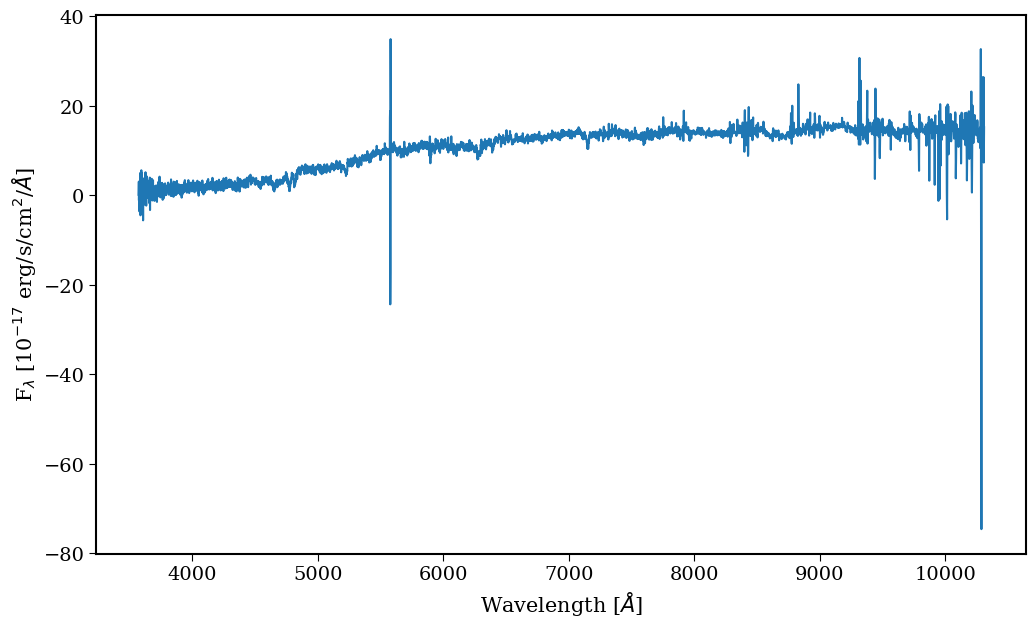

In [6]:
#plotting Spectrum
plt.figure(figsize = (12, 7))
plt.plot(wavelength, flux)
plt.xlabel(r'Wavelength [$\AA$]', fontsize = 15)
plt.ylabel(r'F$_{\lambda}$ [10$^{-17}$ erg/s/cm$^2$/$\AA$]', fontsize = 15)
plt.tick_params(labelsize = 14, length = 5)
plt.show()

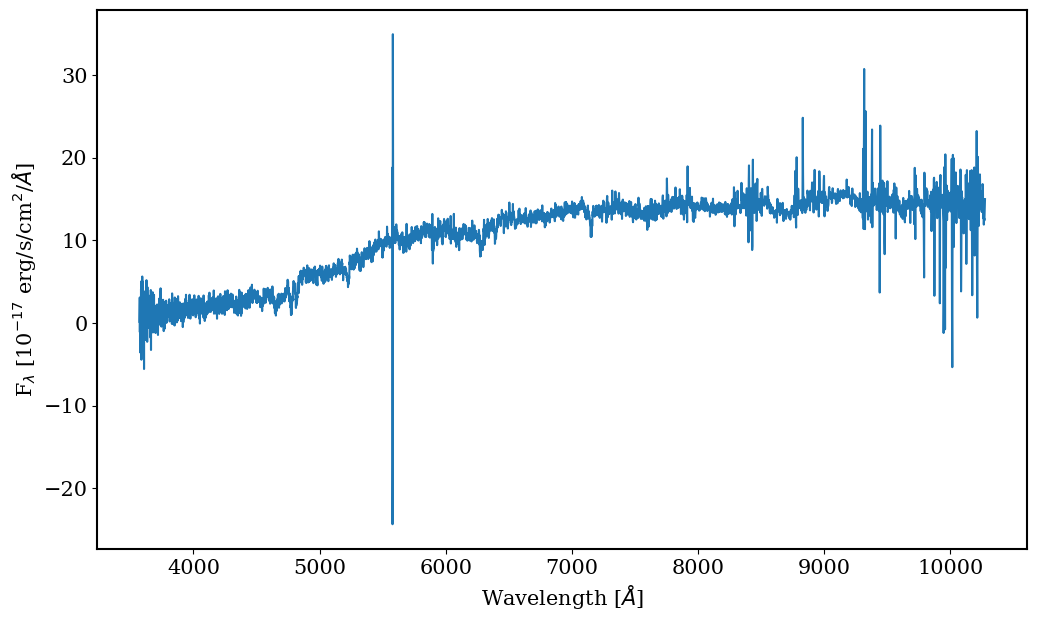

In [7]:
#remove the rightmost noisy feature
clip = 15

wavelength, flux = wavelength[:-clip], flux[:-clip]

plt.figure(figsize = (12, 7))
plt.plot(wavelength, flux)
plt.xlabel(r'Wavelength [$\AA$]', fontsize = 15)
plt.ylabel(r'F$_{\lambda}$ [10$^{-17}$ erg/s/cm$^2$/$\AA$]', fontsize = 15)
plt.show()


# Step 1: Find Redshift

The way we find out the redshift of the galaxy is by matching known emission or absorption features in the spectrum and seeing how far they have been shifted out of their expected rest-frame position. 

In this spectrum it is very noisy and so using emission features could work but it is not a typical star forming galaxy instead we will use absorption features to help us out here. Close to the 5000 Angstrom mark there is a typical feature found in cool stars called the H and K lines. We will use those lines to fit the redshift.

In [8]:
line_names = ['H', 'K']
line_wavelengths = np.array([3968, 3934]) #rest frame wavelengths for H and K lines

In [9]:
#input your guess for a redshift here (Hint: redshift is between 0 - 0.5, and you can use the formula for redshift given earlier in this module to inform your guess)
z = 

#line that redshifts the lines
redshifted_lines = (1+z) * line_wavelengths

#plotting Spectrum
plt.figure(figsize = (12, 7))
plt.plot(wavelength, medfilt(flux, 5))
plt.annotate('H+K', (4650, 0))

#plotting vertical lines for the spectra
plt.axvline(redshifted_lines[0], color = 'black')
plt.annotate(line_names[0], (redshifted_lines[0]+50, 20))
plt.axvline(redshifted_lines[1], color = 'black')
plt.annotate(line_names[1], (redshifted_lines[1]-200, 20))

plt.xlabel(r'Wavelength [$\AA$]', fontsize = 15)
plt.ylabel(r'F$_{\lambda}$ [10$^{-17}$ erg/s/cm$^2$/$\AA$]', fontsize = 15)
plt.show()

SyntaxError: invalid syntax (3898857083.py, line 2)

# 2. Fitting/Removing the Continuum

The continuum holds the shape of the underlying stellar population of a galaxy but it does mess up our ability to measure the flux of a line properly so what we need to do is to somehow fit the broad shape of the continuum so that we can perform accurate line fitting. One technique is applying a broad window filter that will smooth out all the local bumps and wiggles to get the shape of the continuum. You will need to mess around with the optimal window as a window that is too small will reproduce emission and absorption features and we do not want that or a window that is too large will overly smooth so some trial and error is needed to get it just right. Also If you see prominant emission lines in your spectra it would be wise to mask them out (remove them) from the spectra when doing this continuum fitting. This spectra does not have any large emission features so we will just use the broad window filter

In [8]:
from scipy.signal import medfilt

In [12]:
#We need to specify window length try it out and see which window length works best 
#Note: Window length must be odd, and in this case will be quite big
window = 101
continuum_medfilt = medfilt(flux, kernel_size =int(window))

################
#If you got an error above please comment the above line and uncomment the line below
################

#continuum_medfilt = medfilt(flux.astype(float), kernel_size = int(window))

ValueError: dtype=>f4 is not supported by medfilt

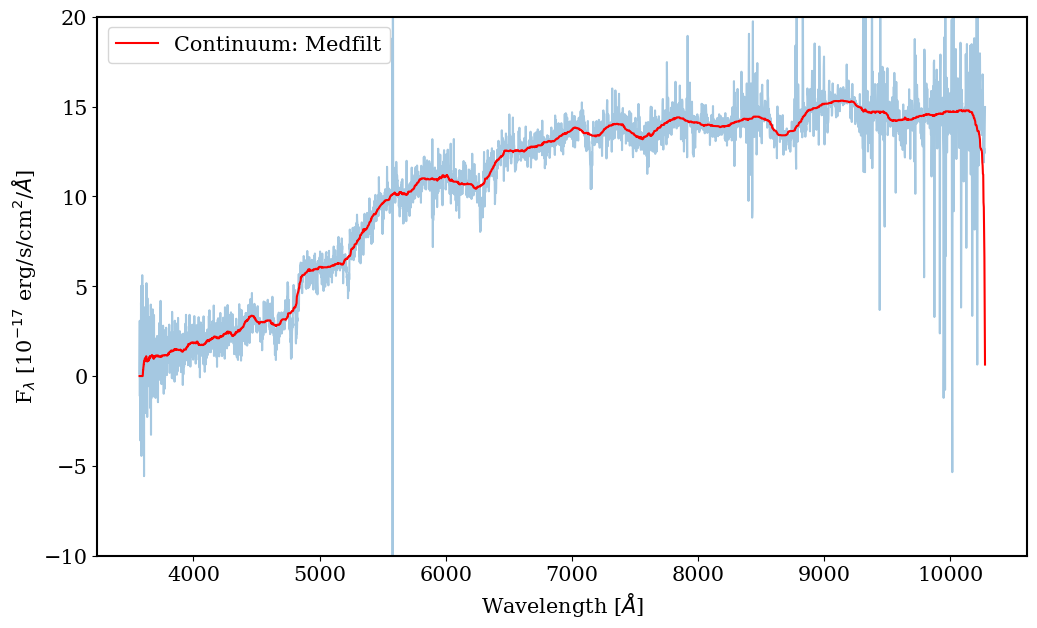

In [13]:
#plotting Spectrum
plt.figure(figsize = (12, 7))
plt.plot(wavelength, flux, alpha = 0.4)

l1, = plt.plot(wavelength, continuum_medfilt, color = 'red')



plt.xlabel(r'Wavelength [$\AA$]', fontsize = 15)
plt.ylabel(r'F$_{\lambda}$ [10$^{-17}$ erg/s/cm$^2$/$\AA$]', fontsize = 15)

plt.legend(handles = [l1], 
           labels = ['Continuum: Medfilt'], 
          fontsize = 15)
plt.ylim(-10, 20)
plt.show()

# Another Example

Let us try using our spectral analysis techniques on another galaxy. This time on a CEERS NIRSpec spectra.

In [14]:
#reading in the file
nirspec_2552 = Table.read('spectra_data1.fits')

In [15]:
#printing out the columns
nirspec_2552.columns

<TableColumns names=('WAVELENGTH','FLUX','FLUX_ERROR','FLUX_VAR_POISSON','FLUX_VAR_RNOISE','FLUX_VAR_FLAT','SURF_BRIGHT','SB_ERROR','SB_VAR_POISSON','SB_VAR_RNOISE','SB_VAR_FLAT','DQ','BACKGROUND','BKGD_ERROR','BKGD_VAR_POISSON','BKGD_VAR_RNOISE','BKGD_VAR_FLAT','NPIXELS')>

In [16]:
#getting the relevant data
wavelength_nirspec, flux_nirspec = nirspec_2552['WAVELENGTH'], nirspec_2552['FLUX']
wavelength_nirspec, flux_nirspec = np.array(wavelength_nirspec).astype(float), np.array(flux_nirspec).astype(float)

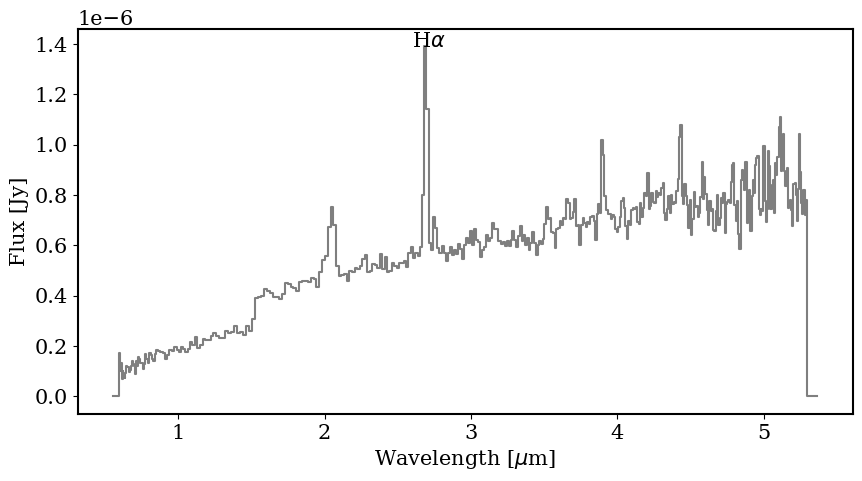

In [17]:
#plotting Spectrum
plt.figure(figsize = (10, 5))

plt.step(wavelength_nirspec, flux_nirspec, color = 'black', alpha = 0.5, where = 'mid')

plt.annotate(r'H$\alpha$', (2.6, 1.39e-6))

plt.xlabel(r'Wavelength [$\mu$m]', fontsize = 15)
plt.ylabel('Flux [Jy]', fontsize = 15)
plt.show()

In [18]:
#removing right-most data as that is all zeroes
wavelength_nirspec, flux_nirspec = wavelength_nirspec[:-10], flux_nirspec[:-10]

In [19]:
#emission lines to check the redshift of this source
line_names = [r'H$\beta$', '[OIII]5007', r'H$\alpha$']
line_wavelengths = np.array([4864, 5007, 6564])

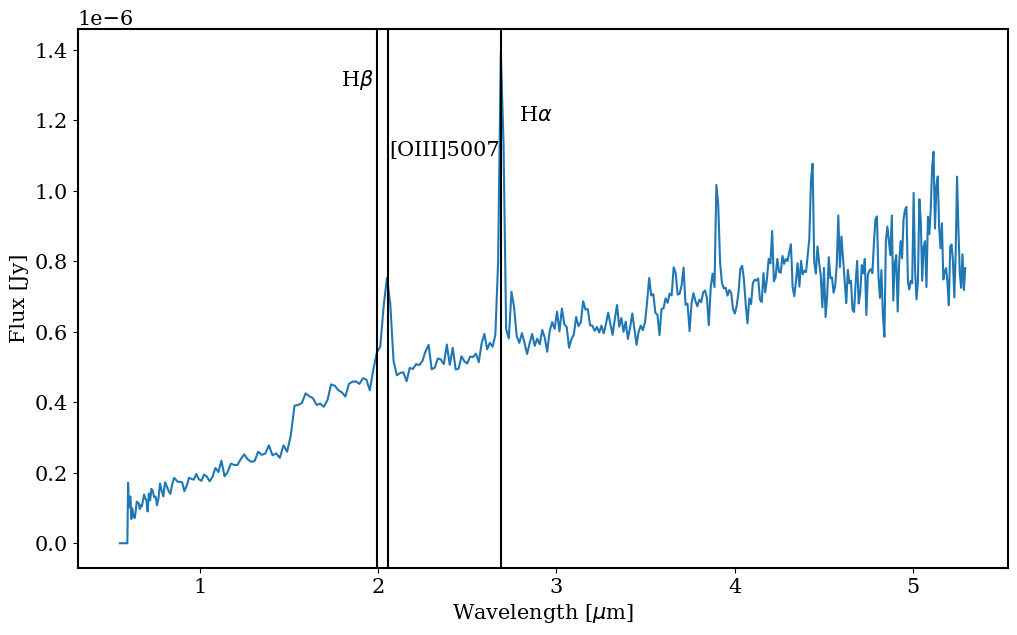

In [21]:
#input your guess for a redshift here
#NOTE: The big peak is Halpha so try to match H-alpha to that (Hint: redshift is between 0 - 5)
z = 3.1

#line that redshifts the lines
redshifted_lines = ((1+z) * line_wavelengths) * u.AA.to(u.micrometer)

#plotting Spectrum
plt.figure(figsize = (12, 7))
plt.plot(wavelength_nirspec, flux_nirspec)

plt.axvline(redshifted_lines[0], color = 'black')
plt.annotate(line_names[0], (redshifted_lines[0]-0.2, 1.3e-6))
plt.axvline(redshifted_lines[1], color = 'black')
plt.annotate(line_names[1], (redshifted_lines[1]+0.01, 1.1e-6))
plt.axvline(redshifted_lines[2], color = 'black')
plt.annotate(line_names[2], (redshifted_lines[2]+0.1, 1.2e-6))

plt.xlabel(r'Wavelength [$\mu$m]', fontsize = 15)
plt.ylabel('Flux [Jy]', fontsize = 15)
plt.show()

In [22]:
#Fitting Continuum
nirspec_medfilt = medfilt(flux_nirspec, 101)

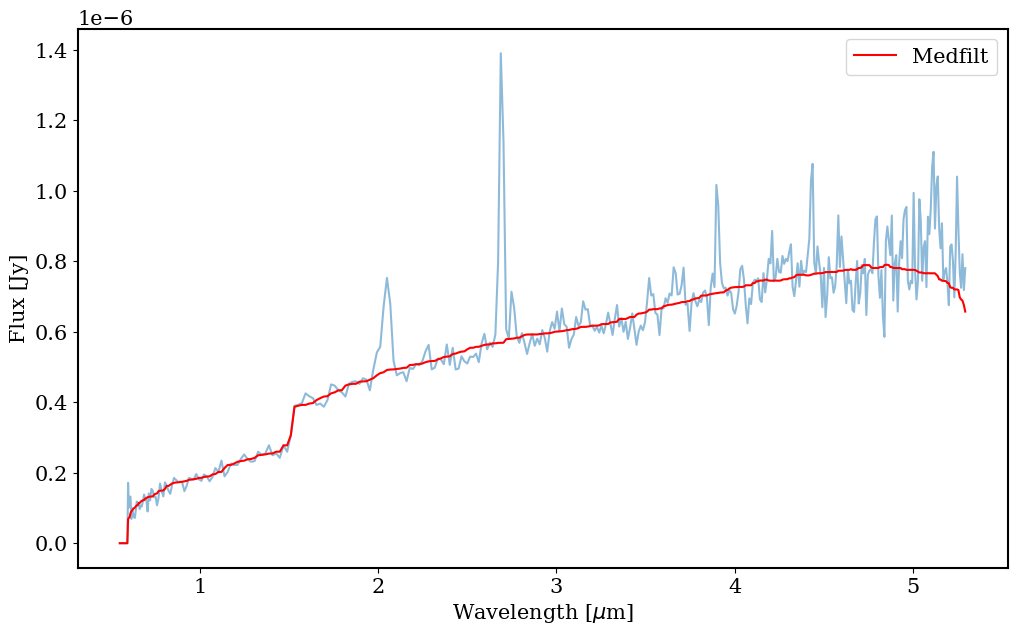

In [23]:
#plotting Spectrum
plt.figure(figsize = (12, 7))
plt.plot(wavelength_nirspec, flux_nirspec, alpha = 0.5)

plt.plot(wavelength_nirspec, nirspec_medfilt, color = 'red', label = 'Medfilt')
plt.xlabel(r'Wavelength [$\mu$m]', fontsize = 15)
plt.ylabel('Flux [Jy]', fontsize = 15)
plt.legend()
plt.show()

# Discussion

One of the things that we can see here is that medfilt seems to capture the break quite well and we want to be able to model the continuum without adding any weird features to the spectrum. So this did a goo djob of capturing the continuum.

# Fitting Emission Lines

The key to working with spectra is being able to measure the line flux of an emission line. This is done by fitting a Gaussian model to the emission line. This process can be a bit more complicated if the lines are blended, meaning that what looks to be one line in the spectra is actually made up of a variety of other emission lines. In the next section we go over how to fit an emission line and slowly increase the complexity of the model and fitting routines.

In [24]:
#subtract continuum for this first fitting method
cont_sub_nirspec_flux = flux_nirspec - nirspec_medfilt

Text(0, 0.5, 'Flux [Jy]')

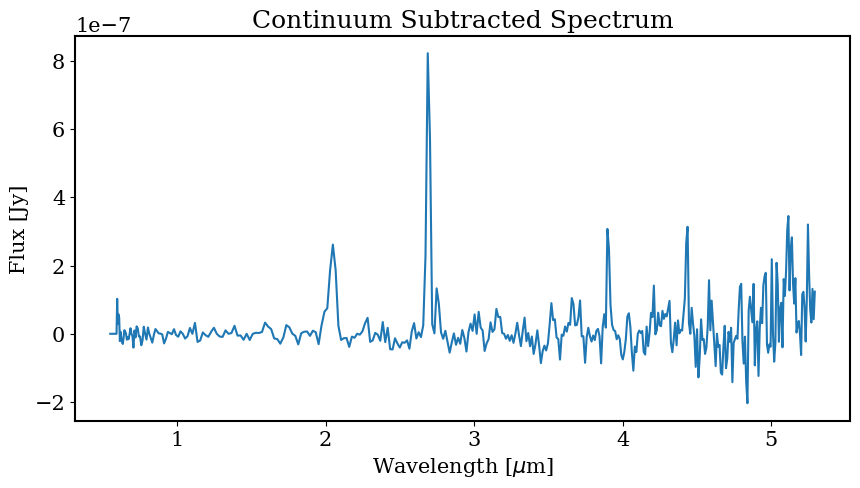

In [25]:
plt.figure(figsize = (10, 5))
plt.title('Continuum Subtracted Spectrum')
plt.plot(wavelength_nirspec, cont_sub_nirspec_flux)
plt.xlabel(r'Wavelength [$\mu$m]', fontsize = 15)
plt.ylabel('Flux [Jy]', fontsize = 15)

# Using Curve Fit

Curve fit is a very powerful tool to fit any model to any kind of data. The power of curve_fit comes from the ability to have a custom model that the user can create. The one condition for this function that the user defines is just that it has to be in the format that curve_fit expects it in. The format for this function is f(x, param1, param2, ...) where x is the first argument in the function and then the rest are the parameters you are trying to fit in any order you like. 

For the purpose of fitting an emission line we will be fitting a Gaussian to this and so our model will have the form:

$G(x) = Ae^{\frac{(x - \mu)^2}{2\sigma^2}}$

Here A represents the amplitude of the Gaussian and controls the height of the Gaussian. $\mu$ controls where the Gaussian is centered and this should correspond to the wavelength of the emission line. $\sigma$ controls how wide the emission line is, a larger value of $\sigma$ means a broader line. x in this example corresponds to your wavelength array. 

Note that the units of A, $\mu$ and $\sigma$ are solely determined by the data you provide curve_fit. So if the spectra is in units of Jy then the Amplitude will have units of Jy, if the wavelength inputted is in microns then $\mu$ and $\sigma$ will be in microns. 

The function curve_fit takes in some parameters and then you can customize it further with other key-word arguments. The basic input to get curve_fit to start fitting is it needs the model that you are trying to fit in the format specified above, the x and y data, and an intitial guess to start the process to finding the best fit parameters.

    Inputs:
    Model Function
    x-data
    y-data
    Initial Guesses

The output of curve fit will be two things, the first thing you will get back is the best fit parameter values and the second is a covariance matrix that holds the uncertainties and correlations of each of the parameters. The thing we are really after is the best fit parameters so we will not cover the covariance matrix in too much detail as we will be using more sophisticated ways of getting the error on our parameters in the upcoming notebooks.

    Outputs:
    Best Fit Parameters
    Covariance Matrix

The best fit parameters will be stored in one variable as a list and they will be in the same order as your user-defined model, so to access a certain parameter you will need to use python indexing for that. 

Let us code this model up in Python and use it to fit an emission line.

In [26]:
from scipy.optimize import curve_fit

In [27]:
#defining the model for the emission line as a Gaussian
def line_model(x, A, mu, sigma):
    
    '''
    This is the model for the emission line. Only to be used on a continuum subtracted spectrum.
    
    Gauss = Ae^(-(x-mu)^2/2 sigma^2)
    
    '''
    
    return A*np.exp(-(x - mu)**2/(2*sigma**2))

# Zooming in on the emission line

If you provide curve fit with the entire x and y data of the spectrum it will use all that info in the estimation of the parameters. This is a bit much for our purposes as we are only focused on one line so we will only provide curve fit with the data around the emission line. 

Let us do this by looking around a window near the emission line and using only this data into curve_fit.

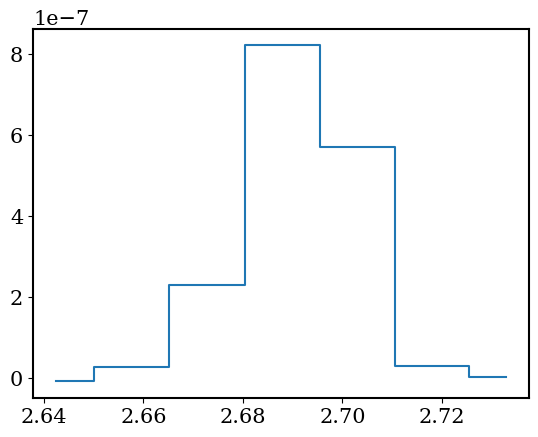

In [28]:
#selecting the region of the spectrum just around the emission line
select_window = .05
idx_line_region = np.where((redshifted_lines[-1] - select_window < wavelength_nirspec) & \
                            (wavelength_nirspec < redshifted_lines[-1] +select_window))

plt.step(wavelength_nirspec[idx_line_region], cont_sub_nirspec_flux[idx_line_region], where = 'mid')
plt.show()

In [29]:
#curve_fit requires initial guesses for it to start the fitting
#p0 will hold the initial guess on the parameters A, mu, and sigma for the line model

#      A              mu          sigma
p0 = [8e-7, redshifted_lines[-1], .02]

#code that performs the least square fitting
popt, cov = curve_fit(line_model, #function to fit
                      wavelength_nirspec[idx_line_region], #xdata
                      cont_sub_nirspec_flux[idx_line_region], #ydata
                      p0 = p0) #initial guesses

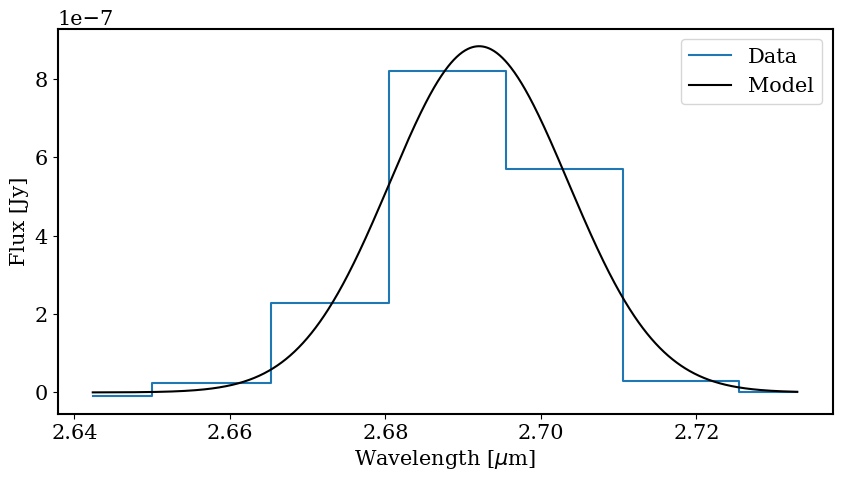

In [30]:
#xarray to use for plotting the model against the data
#Usually we do this to make the model resolution higher than the original data
xarr = np.linspace(wavelength_nirspec[idx_line_region][0], 
                  wavelength_nirspec[idx_line_region][-1], 
                   1000)

plt.figure(figsize = (10, 5))

l1, = plt.step(wavelength_nirspec[idx_line_region], 
         cont_sub_nirspec_flux[idx_line_region], 
         where = 'mid')

l2, = plt.plot(xarr, line_model(xarr, *popt), color = 'black')

plt.legend(handles = [l1, l2], 
          labels = ['Data', 
                    'Model'], 
          fontsize = 15)

plt.xlabel(r'Wavelength [$\mu$m]', fontsize = 15)
plt.ylabel('Flux [Jy]', fontsize = 15)

plt.show()


# A bit more complicated model

The last example showed us how we can use curve_fit to fit a Gaussian to the emission lines with the continuum subtracted, in this next example we are going to add in a bit more complexity by not removing the continuum but fitting it as well. We will do this by making the model near the emission line to be a combination of a Gaussian and a line. We use a Gaussian because that is what the line will be and the line will represent the continuum. 

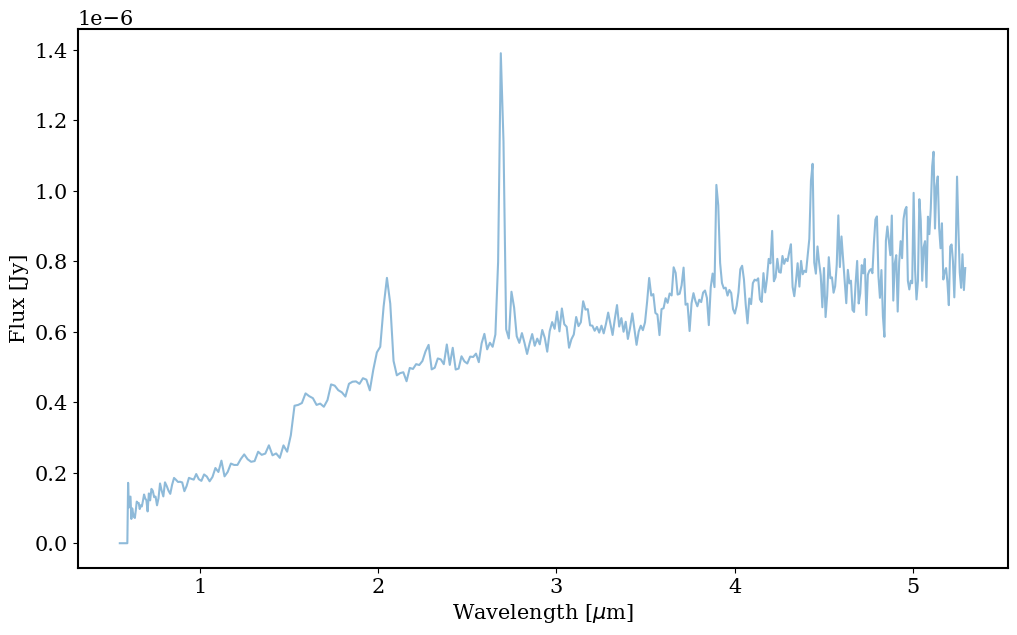

In [31]:
#plotting the spectrum
plt.figure(figsize = (12, 7))
plt.plot(wavelength_nirspec, flux_nirspec, alpha = 0.5)
plt.xlabel(r'Wavelength [$\mu$m]', fontsize = 15)
plt.ylabel('Flux [Jy]', fontsize = 15)
plt.show()

In [32]:
line_center = 2.69

In [33]:
def continuum_model(x, m, b):

    continuum = m*(x - line_center) + b  #similar to y = mx+b

    return continuum

def gaussian_model(x, A, mu, sigma):

    gauss = A*np.exp(-(x - mu)**2/(2*sigma**2))

    return gauss

In [34]:
def line_plus_continuum(x, A, mu, sigma, m, b):
    
    '''
    Making the line plus gaussian model to use into curve_fit. 
    
    Model = Gaussian + line
    Model = Ae^(-(x-mu)^2/sigma^2) + m(x - line_center) + b
    '''
    
    line = gaussian_model(x, A, mu, sigma)
    continuum = continuum_model(x, m, b)
    
    return line + continuum

In [35]:
#As with the previous example we need an initial guess for curve_fit but now we added in two more parameters
#so the initial guesses will be for A, mu, sigma, m, and b

#.       A              mu         sigma   m  b
p0 = [1.4e-6, redshifted_lines[-1], .02, .01, 0]

popt, cov = curve_fit(line_plus_continuum, #model
                      wavelength_nirspec[idx_line_region], #xdata
                      flux_nirspec[idx_line_region], #ydata
                      p0 = p0) #initial guesses

In [36]:
xarr = np.linspace(wavelength_nirspec[idx_line_region][0], 
                   wavelength_nirspec[idx_line_region][-1], 
                   1000)

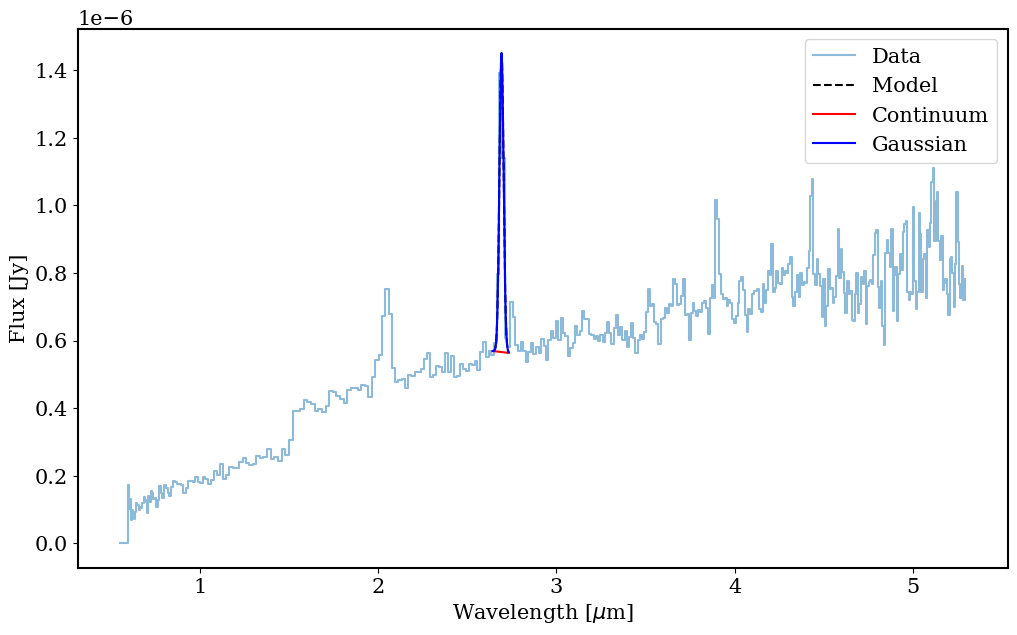

In [37]:

continuum_line = continuum_model(xarr, popt[-2], popt[-1])
gauss_line = gaussian_model(xarr, popt[0], popt[1], popt[2]) + continuum_line


plt.figure(figsize = (12, 7))
l1, = plt.step(wavelength_nirspec, flux_nirspec, alpha = 0.5, where = 'mid')
l2, = plt.plot(xarr, line_plus_continuum(xarr, *popt), color = 'black', linestyle = '--')
l3, = plt.plot(xarr, continuum_line, color = 'red')
l4, = plt.plot(xarr, gauss_line, color = 'blue')

plt.xlabel(r'Wavelength [$\mu$m]', fontsize = 15)
plt.ylabel('Flux [Jy]', fontsize = 15)

plt.legend(handles = [l1, l2, l3, l4], 
          labels = ['Data', 
                    'Model', 
                    'Continuum',
                    'Gaussian'], 
          fontsize = 15)

plt.show()

# Zooming in around the line

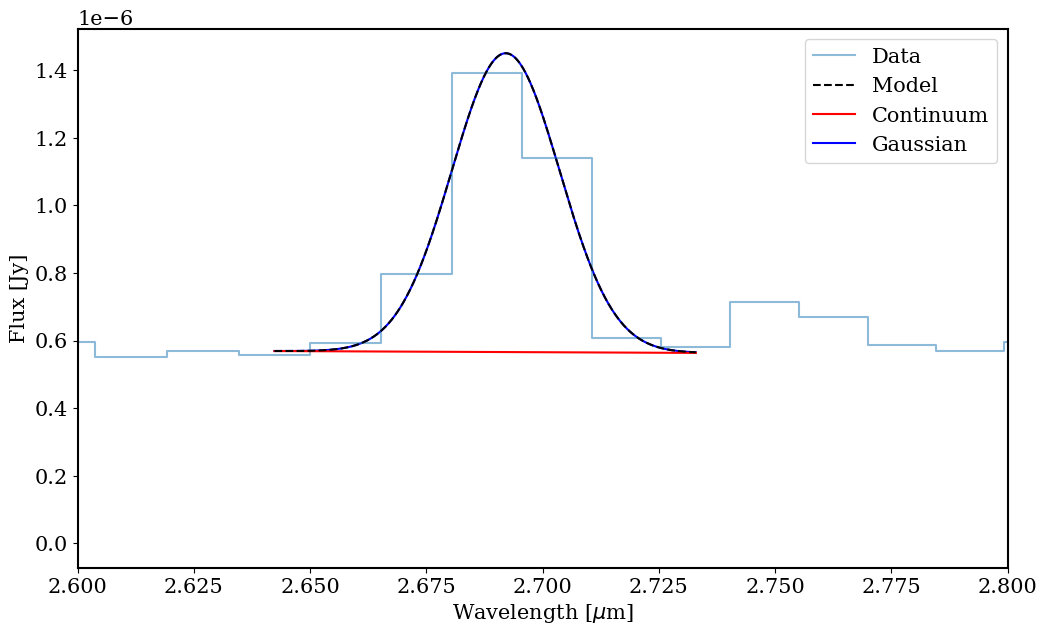

In [38]:

continuum_line = continuum_model(xarr, popt[-2], popt[-1])
gauss_line = gaussian_model(xarr, popt[0], popt[1], popt[2]) + continuum_line


plt.figure(figsize = (12, 7))
l1, = plt.step(wavelength_nirspec, flux_nirspec, alpha = 0.5, where = 'mid')
l2, = plt.plot(xarr, line_plus_continuum(xarr, *popt), color = 'black', linestyle = '--', zorder = 99)
l3, = plt.plot(xarr, continuum_line, color = 'red')
l4, = plt.plot(xarr, gauss_line, color = 'blue', zorder = 1)

plt.xlabel(r'Wavelength [$\mu$m]', fontsize = 15)
plt.ylabel('Flux [Jy]', fontsize = 15)

plt.legend(handles = [l1, l2, l3, l4], 
          labels = ['Data', 
                    'Model', 
                    'Continuum',
                    'Gaussian'], 
          fontsize = 15)
plt.xlim(2.6, 2.8)
plt.show()

# A bit more complicated example

The last example showed how to fit both the emission line and the continuum, in this example we are going to now add in a bit more complexity by fitting multiple lines. When you did the redshift match you may have noticed that the bump leftward of Halpha is actually a combination of [OIII]5007 and Hbeta but it is actually made up of three lines as [OIII]4969 is also in there. We are going to try to fit this line with the three models to get the flux for each line individually and we will do so by making a more complicated model and take some advantages of the [OIII] lines to simplify the fitting.

In [47]:
def gauss_model(x, A, mu, sigma):
    
    '''
    Basic Gaussian model 
    '''
    
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

def line(x, m, b):
    
    '''
    Basic Line model
    '''
    return m*(x - line_center)+b

def model(x, A1, A2, mu1, mu2, sigma1, sigma2, m, b):
    
    '''
    This will hold the models for the three gaussian plus the line model for the continuum
    '''
    
    #making the hbeta model A1, mu1 and sigma1 will be the values for Hbeta
    hbeta = gauss_model(x, A1, mu1, sigma1)
    
    
    #since OIII is the same species they would be affected the same so the sigma will be the same between 
    #these two lines
    #there is also a theoretical amplitude that is fixed A_5007/A_4969 = 3
    #We will use this to only fit for the amplitude for the 5007 and we will scale the 4969 based off of the 
    #5007 amplitude
    
    oiii4969 = gauss_model(x, A2/3, mu2 *(4960/5007), sigma2)
    oiii5007 = gauss_model(x, A2, mu2, sigma2)
    
    continuum = line(x, m, b)
    
    return hbeta+oiii4969+oiii5007+continuum

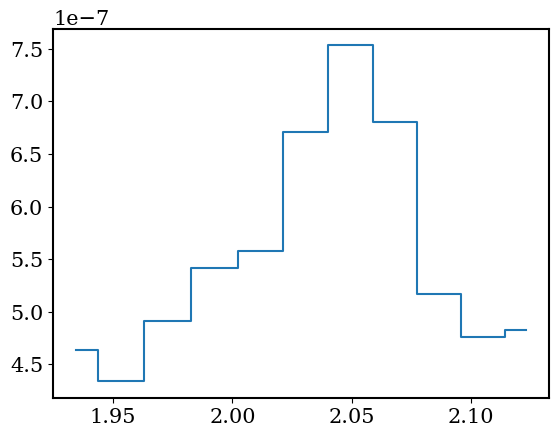

In [40]:
#selecting the region of the spectrum just around the emission line
select_window = .1
idx_line_region = np.where((2.03 - select_window < wavelength_nirspec) & \
                            (wavelength_nirspec < 2.03 +select_window))

plt.step(wavelength_nirspec[idx_line_region], flux_nirspec[idx_line_region], where = 'mid')
plt.show()

In [48]:
#initial guesses for the model

#.     A1.   A2.       mu1                   mu2                 sigma1 sigma2   m.   b
p0 = [1e-7, 2e-7, redshifted_lines[0],  redshifted_lines[1], .03,     .02, .4e-6, 0]

#imposing some upper and lower bounds on the parameters so that they do not go to any weird values
#this is useful if you know any priors on parameters such as Amplitudes or sigma widths
low_bounds =  (0   ,    0, 1.95, 1.95,   0,   0, 0, -1)
high_bounds = (8e-7, 8e-7, 2.11, 2.11, .1, .1, 10e-7, 1)

popt, cov = curve_fit(model, 
                      wavelength_nirspec[idx_line_region], 
                      flux_nirspec[idx_line_region], 
                      p0 = p0, 
                      bounds = (low_bounds, high_bounds))

In [42]:
popt

array([9.79306754e-08, 2.03697977e-07, 1.99771362e+00, 2.05140587e+00,
       3.02872175e-02, 1.97826899e-02, 3.99729596e-07, 7.15140853e-07])

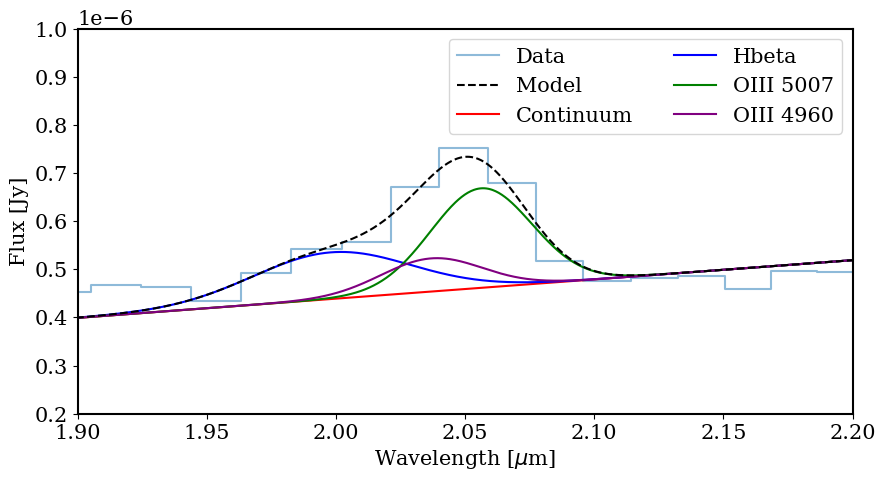

In [50]:
xarr = np.linspace(1.8, 2.2, 1000)
continuum_line = line(xarr, popt[-2], popt[-1])

#A1, A2, mu1, mu2, sigma1, sigma2, m, b
hbeta = gauss_model(xarr, popt[0], popt[2], popt[4]) + continuum_line
OIII5007 = gauss_model(xarr, popt[1], popt[3], popt[5]) + continuum_line
OIII4960 = gauss_model(xarr, popt[1]/3, popt[3]*(4960/5007), popt[5]) + continuum_line

plt.figure(figsize = (10, 5))
l1, = plt.step(wavelength_nirspec, flux_nirspec, alpha = 0.5, where = 'mid')
l2, = plt.plot(xarr, model(xarr, *popt), color = 'black', linestyle = '--', zorder = 99)
l3, = plt.plot(xarr, continuum_line, color = 'red')
l4, = plt.plot(xarr, hbeta, color = 'blue')
l5, = plt.plot(xarr, OIII5007, color = 'green')
l6, = plt.plot(xarr, OIII4960, color = 'purple')

plt.xlabel(r'Wavelength [$\mu$m]', fontsize = 15)
plt.ylabel('Flux [Jy]', fontsize = 15)

plt.legend(handles = [l1, l2, l3, l4, l5, l6], 
          labels = ['Data', 
                    'Model', 
                    'Continuum', 
                     'Hbeta',
                     'OIII 5007',
                     'OIII 4960'], 
          fontsize = 15, 
          ncols = 2)
plt.xlim(1.9, 2.2)
plt.ylim(.2e-6, 1e-6)
plt.show()

# Calculating Flux

When we are fitting a gaussian to an emission line our end goal is to compute the flux of that emission line. When we use a Gaussian as our fitting function we can exploit the fact that the integral of a Gaussian from $-\inf$ to $+\inf$ has a nice functional form: $A\sigma\sqrt{2\pi}$. Here A is the amplitude of the Gaussian, $\sigma$ is the standard deviation of the Gaussian. 

# Note on Units:

Flux has units of energy/s/Area, when we work with spectra they are either in $F_{\nu}$ or $F_{\lambda}$ or some units that relates to these two like the Jansky. When you are trying to compute fluxes you need to ensure that the units of your amplitude and the $\sigma$ work in such a way that you get back the units of flux which in general terms are energy/s/Area. 

Let look at an example where Amplitude is in $F_{\nu}$ in Jy and the sigma is in microns. Similar to some JWST spectra you may be working with. 

If we take the amplitude to be $F_{\nu}$: erg/s/cm^2/Hz and if we have sigma in microns we have the following:

$F[units] = \frac{erg}{s cm^2 Hz} * \mu m$


The above units **DO NOT** give back the units of flux we need as the Hz and $\mu$ m do not cancel out. Thus, you need to make sure that you convert the flux to $F_{\lambda}$ which has units of erg/s/cm^2/Angstroms and then convert your wavelength to Angstroms. If you do this then you get the following:

$F[units] = \frac{erg}{s cm^2 \AA} * \AA =  \frac{erg}{s cm^2}$

The $\AA$ cancels out between the two and then you are left with something in units of energy/s/Area which is erg/s/$cm^2$. 

Let us see how we can get flux from this spectra after performing the fitting by analyzing the best fit parameters and their units. 

In [ ]:
#popt holds the best fit parameters for the model
#it is in the order
#A1, A2, mu1, mu2, sigma1, sigma2, m, b
#where A1 and sigma1 are tied to the Hbeta line
#A2 and sigma2 are tied to the OIII lines
#Where A2 is the amplitude of the 5007 line and we can get the amplitude of the 4960 line
#by dividing A2 by 3 and its is in the units of the input spectrum, so in this case Jy
#sigma of the 4960 line is the same as the 5007 line
#mu1 and mu2 are the central wavelengths of the lines in the units of the input data
#so in this case microns
popt

In [ ]:
#you can see if we naively take the Ampltude and sigma from the best fit values
#the units do not work out to get us flux in erg/s/cm^2 since A is in Jy
#sigma is in microns
#We need to perform some unit conversions to get the flux in erg/s/cm^2
flux = popt[0]*popt[2]*np.sqrt(2*np.pi)

In [ ]:
c = 3e18 #speed of light in Angstrom/s
A_cgs_Hb = popt[0]*1e-23 #converts Jansky to erg/s/cm^2/Hz (1 Jy = 1e-23 erg/s/cm^2/Hz)
microns_to_angstroms = popt[2]*1e4 #1e4 converts microns to Angstroms

A_flambda = A_cgs_Hb * c/microns_to_angstroms**2 # we need to multiply by the conversion factor c/lambda^2

flux = A_flambda * microns_to_angstroms * np.sqrt(2*np.pi)

# Concluding Remarks

When calculating flux you can go through the above exercise to convert the units correctly. Another approach you can do is to convert the input spectrum to be in $F_{\lambda}$, $erg/s/cm^2/\AA$, and then convert your wavelength array to Angstroms. This will ensure that everything is already in the correct units and you can apply:

$Flux = A\sigma\sqrt{2\pi}$

Directly since the input spectrum and wavelengths are in the correct units for the $\AA$ to cancel out in the final flux calculation.